In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import statsmodels
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os

In [2]:
def load_data(filename):
    df = pd.read_csv(filename, header=None, names=['participant_id','i','ts','info'])
    result = {}
    for participant_id in df['participant_id'].unique():
        if any(part in participant_id.lower() for part in ["debug", "test", "noas", "null"]):
            continue
        events = [json.loads(e) for e in df[df['participant_id'] == participant_id]['info']]
        result[participant_id] = sorted(events,key=lambda e:e['event_time'])
    return result

def get_events_with_type(f, event_type):
    return [e for e in f if e['event_type'].replace('_',' ') == event_type.replace('_', ' ')]

def get_parsed_data(data):
    your_turn_events = get_events_with_type(data,'your turn')
    user_move_events = get_events_with_type(data,'user move')
    assert(len(your_turn_events)==len(user_move_events))
    return [(e['event_info']['bp'],e['event_info']['wp'],e['event_info']['tile'],
             e['event_info']['user_color'],(e['event_time']-e_your_turn['event_time'])/1000)
            for e_your_turn,e in zip(your_turn_events,user_move_events)]

def should_be_equal(name, actual, expected, warnings):
    if expected != actual:
        warnings.append(f"{name} was expected to be {expected} but was {actual}")

def check_event_counts(data,num_games):
    event_count_dict = defaultdict(lambda: 0, dict(zip(*np.unique([e['event_type'] for e in data],return_counts=True))))
    warnings = []
    should_be_equal("Number of game starts", event_count_dict['start game'], num_games, warnings)
    should_be_equal("Number of game endings", event_count_dict['end game'], num_games, warnings)
    should_be_equal("User moves", event_count_dict['user move'], event_count_dict['your turn'], warnings)
    should_be_equal("Opponent moves", event_count_dict['opponent move'], event_count_dict['waiting for opponent'], warnings)
    should_be_equal("Game outcomes", event_count_dict['opponent win'] + event_count_dict['user win'] + event_count_dict['draw'], event_count_dict['start game'], warnings)
    return warnings

In [4]:
# directory where your data is stored
direc = '/Users/ilima/git/Four_in_a_row/Four_in_a_row_Analyses/Experiment code and data parse notebook/'
direc = '../Analysis notebooks/data/'
#name of the user whose data you want to analyze
#usernames = ['118:R_28AEWB4BHHAp3ic', '159:R_3kolXJjcfDsjL6k', '154:R_3kgZuiVj87g1GNO', '143:R_1PRYqkSFZQYTVUg', 
#            '160:R_3h5POosYswsLZqe', '153:R_reR4dauvBGinQvT', '131:R_3iJ8A5hXnygbqAF', '116:R_3qeT0l1LS4myHr4',
 #         '115:R_241tt6O6tVQs9NR', '128:R_AEYAh7gikx2YEvL', '106:R_1HqNZ7zU4Tb0SSR', '142:R_1InpeBO876j23Eh,
  #        '168:R_2ARs0RJIBjJZhYL']
#usernames = ['169:R_RQyaj0YbKu9fsDT', '141:R_1CK2JfPijAWf85C', '195:R_22tOmOP9V3YTA0u']
#usernames = ['A507:R_2b176cnRCyapnkx', 'A106:R_x6jDmbRb3oyYGdz', 'A108:R_2TnOx7dVPSonpTg', 'A116:R_cu9t4ZNp60qTplf',
#            'A120:R_PONVLZnwDK7wSpr', 'A123:R_2viEesh2c9XCBMe']
usernames = ['A112:R_1DSHShmupLFd4m9','A101:R_Q0Jd5lCBrQu5Dm9', 'A121:R_3j2tErwVrBPXWAH', 
             'A1083:R_0OFsszTuxG152et', 'A103:R_3lJsCIPqfpqRhkf', 'A130:R_zUdkqlxVsz3sXcJ',
            '101:R_31SM3mwQvAhBwar', '102:R_vdABJ1XvXNriwff', '107:R_2ahKzS67s2u094R',
            '117:R_2XpQzVOPaMJjkCo', '121:R_2zoxitKzRuYUblm', '129:R_2q8z9DfvMUHDZio',
            '139:R_1F5MGuZ2rKZOLnc', '152:R_XEQd4AtPvWuAWnT', '149:R_shhEOP9BPIFkz97', '150:R_3ilNhJufw9u0JJr',
            '156:R_2TTetTXWqRwQOGb', '166:R_9Nac2hjg6u7BlS1', '137:R_2X1ycnpBX7zJOwI',
            '256:R_10BfVTQovUcZioM', '175:R_2vjnTMhG0Bpa7wq', '181:R_3fDgQlApbcv1n4e',
            '187:R_3oHOHstFKN4HiLA', '192:R_1LeQOpZ9pat1k7D', '199:R_D1Afhly6eOCY66B',
             '201:R_3kzZPXnjFGbpt30', '202:R_2OHMsGSLXJZG0Bc', '200:R_1NCzjmN3Hl5r3HF',
             '194:R_24rdiskqYQc7BsO', '196:R_0voL9dLPRpILrS9', '197:R_bqny5leXGykyp0t',
             '179:R_2xV1IwgJyplwuvp', '180:R_1OGFPUUh0z8rWBh', '250:R_r2BwOdT2hnmQ5WN',
             '273:R_2zuodaGDxpO8dfe', '281:R_NVGtaI93MLLVQfT', '290:R_25zHKt5eqk2Fr1k',
             '305:R_WBOZ0yrZfLTCClz', '842:R_3jciZNiYxaSffqd',
             '846:R_z1hBUlYMwkfdbGh', '844:R_2D6PtBpvztH0yVh', '849:R_1im5d5ENT1vk0Xm',
             '856:R_3EEYoLyNN9SpuuT', '149:R_shhEOP9BPIFkz97', '150:R_3ilNhJufw9u0JJr',
             '156:R_2TTetTXWqRwQOGb', '166:R_9Nac2hjg6u7BlS1', '137:R_2X1ycnpBX7zJOwI',
             
            '859:R_2TIcY7St40mDSbp', '832:R_xlnbFfl5i6Zgz5v',
            '858:R_3NR4vGxEweQ74vU', '833:R_1IsH6cT55Ys9Qu4', '834:R_30ppJhWfEZIOoSi', '182:R_3NEgCFlK1BFSmdZ',
            '183:R_2uPQbPniskmS0Ep', '208:R_2AST2XkjQUqflkc', '212:R_OOl4OrOpRgbrLBD', '215:R_32R47f1GRrLhRdX',
            '228:R_ULyuWg2JwZBuGiJ', '245:R_eINRkRhqhKHRjzz', '231:R_2QRpawEy8w6txvN', '226:R_2X10rcLujzFpHxv', 
            '236:R_24qFUPTZKx0SybQ', '249:R_d1i4xMt2Vzivxg5', '216:R_21j62EoiJ63yEJ5', '217:R_1JPc2llYzw1ezqs',
            '227:R_2qlLx30lmNEXUJL', '230:R_28G5rUmynDONqbJ', '209:R_1esokoelkIOTy89', '242:R_12lQaNUgCpqQizh',
            '248:R_1Do3QQWN7pWkPwQ', '171:R_1Qck2ykGDls2DLz', '221:R_2wvlbfkxX6e4M29', '229:R_3KxYOzYEKloODvs']

#'841:R_25ZiTXX4Zh9Hnjz' completed 31 games but can later be included

#load other datafiles
age = pd.read_csv(direc + "SubjectAge.csv")
bins = [7, 12, 18, 26]
age['ageBins'] = pd.cut(age['FlooredAge'], bins)

usernames_df = pd.DataFrame(usernames, columns=["Username"])
usernames_df['subject'] = usernames_df.index + 1
pars = pd.read_csv(direc + "paramsMatrix.csv", index_col=None)
pars = pd.merge(pars, usernames_df, on='subject', how='outer')
pars['StudyID'] = pars['Username'].str.split(':').str[0]
pars = pd.merge(age, pars, on='StudyID', how='outer')
# pars = pars[pars['iteration'].notna()]

df_rt = pd.read_csv(direc + "reactiontimes.csv")
df_rt['StudyID'] = df_rt['User'].str.split(':').str[0]
df_rt = pd.merge(age, df_rt, on='StudyID', how='outer')
# df_rt.to_csv(r'/Users/ilima/Google Drive/Projects/Cate Hartley Weiji/4inarow_fitting_results/df_rt.csv', index = False) 



In [5]:
#name of your data file
filename = 'trialdata.csv'
data_dict = load_data(filename)
data = [data_dict[username] for username in usernames]
len(data)

74

In [6]:
# create reaction times csv
with open(direc + "reactiontimes.csv", "w") as outfile:
    outfile.write("User,GameNr,Category,Level,MoveNr,RT,UserMoves,OpponentMoves,Result\n")
    for username in usernames:
        # First go through all the events and record gane results
        game_data = {}
        for event in data_dict[username]:
            if event["event_type"] == "start game":
                user_moves = 0
                opponent_moves = 0
            elif event["event_type"] == "user move":
                user_moves += 1
            elif event["event_type"] == "opponent move":
                opponent_moves += 1
            elif event["event_type"] == "end game":
                # practice rounds will be overwritten because the "real" rounds have the same game_num
                game_data[event["event_info"]["game_num"]] = {
                    "user_moves": user_moves,
                    "opponent_moves": opponent_moves,
                    "outcome": event["event_info"]["result"]
                }
        is_practice = False
        # Go through all the events a second time and write csv lines as we go
        for event in data_dict[username]:
            if event["event_type"] == "start game":
                ei = event["event_info"]
                game_nr = ei["game_num"]
                move_nr = 0
                is_practice = ei["is_practice"]
                game_info = ",".join([str(x)for x in [game_nr, ei["category"], ei["level"]]])
            elif event["event_type"] == "your turn":
                prompt_time = int(event["event_time"])
            elif event["event_type"] == "user move":
                if is_practice:
                    continue
                move_time = int(event["event_time"])
                move_nr += 1
                gd = game_data[game_nr]
                line = ",".join([username, game_info, str(move_nr), str((move_time - prompt_time) / 1000), str(gd["user_moves"]), str(gd["opponent_moves"]), gd["outcome"]])
                outfile.write(line + "\n")

In [7]:
# Create durations csv
with open(direc + "gameDurations.csv", "w") as outfile:
    outfile.write("User,TotalDurationSeconds,MainDurationSeconds,GamesPlayed\n")
    for username in usernames:
        games_played = 0
        startTime = 0
        endTime = 0
        events = data_dict[username]
        for event in events:
            if event["event_type"] == "start game" and event["event_info"]["game_num"] == 0:
                # Practice and main task both have a game 0, but main task is assigned last
                startTime = event["event_time"]
            elif event["event_type"] == "end game":
                # The endtime keeps being overwritten so we end up with the last one
                endTime = event["event_time"]
                games_played = event["event_info"]["game_num"] + 1 # 0-indexed
        line_elements = [username]
        line_elements.append(str((endTime - events[0]["event_time"]) / 1000) if len(events) >= 1 else "-")
        line_elements.append(str((endTime - startTime) / 1000))
        line_elements.append(str(games_played))
        outfile.write(",".join(line_elements) + "\n")

In [8]:
#the second argument in check_data is the number of games that ought to exist for this user
#if this function failes an assertion, something is wrong with your data, including practise trials
#this function will print the count of all the event type in the data
had_warnings = False
for index in range(len(data)):
    d = data[index]
    warnings = check_event_counts(d,37)
    if warnings:
        had_warnings = True
        print(usernames[index] + " " + "; ".join(warnings))
    for bp,wp,m,c,rt in get_parsed_data(d):
        assert(len(bp.split('1'))-len(bp.split('1')) in [0,1])
print("Some things didn't add up!" if had_warnings else "Everything looks ok")

187:R_3oHOHstFKN4HiLA Number of game endings was expected to be 37 but was 36; Game outcomes was expected to be 37 but was 36
250:R_r2BwOdT2hnmQ5WN Number of game starts was expected to be 37 but was 36; Number of game endings was expected to be 37 but was 36
Some things didn't add up!


In [1]:
def categoryHist(username, data):
    table = np.empty([0,6])
    category = 2
    for event in data:
        if event['event_type'] == 'user move':
            color = event['event_info']['user_color']
        if event['event_type'] == 'adjust level':
            category = event['event_info']['category']
        if event['event_type'] == 'end game':
            result = event['event_info']['result']
            resultCode = 1 if result == 'win' else -1 if result == 'opponent win' else 0
            table = np.vstack((table, [username, event['event_info']['game_num'], int(category), event['event_info']['level'], color, resultCode]))
    return table

In [10]:
#create dataframe
dataframeData = np.empty([0,6]) 
for index in range(len(data)):
    d = data[index]
    dataframeData = np.vstack((dataframeData, categoryHist(usernames[index], d)))
dataFrame = pd.DataFrame(data = dataframeData, columns = ['subject', 'gameNumber', 'category', 'level', 'user_color', 'outcome'])

# dataFrame.to_csv(r'/Users/ilima/Google Drive/Projects/Cate Hartley Weiji/4inarow_fitting_results/forElo.csv', index = False)
dataFrame.to_csv(direc + 'forElo.csv', index = False)
print(f"{len(pd.unique(dataFrame['subject']))} subjects")
dataFrame

69 subjects


,subject,gameNumber,category,level,user_color,outcome
0,A112:R_1DSHShmupLFd4m9,0,2,1,black,1
1,A112:R_1DSHShmupLFd4m9,1,2,11,white,1
2,A112:R_1DSHShmupLFd4m9,0,3,14,black,1
3,A112:R_1DSHShmupLFd4m9,1,3,28,white,1
4,A112:R_1DSHShmupLFd4m9,2,4,31,black,1
...,...,...,...,...,...,...
2731,229:R_3KxYOzYEKloODvs,30,12,112,black,1
2732,229:R_3KxYOzYEKloODvs,31,12,117,white,1
2733,229:R_3KxYOzYEKloODvs,32,13,127,black,1
2734,229:R_3KxYOzYEKloODvs,33,14,138,white,-1


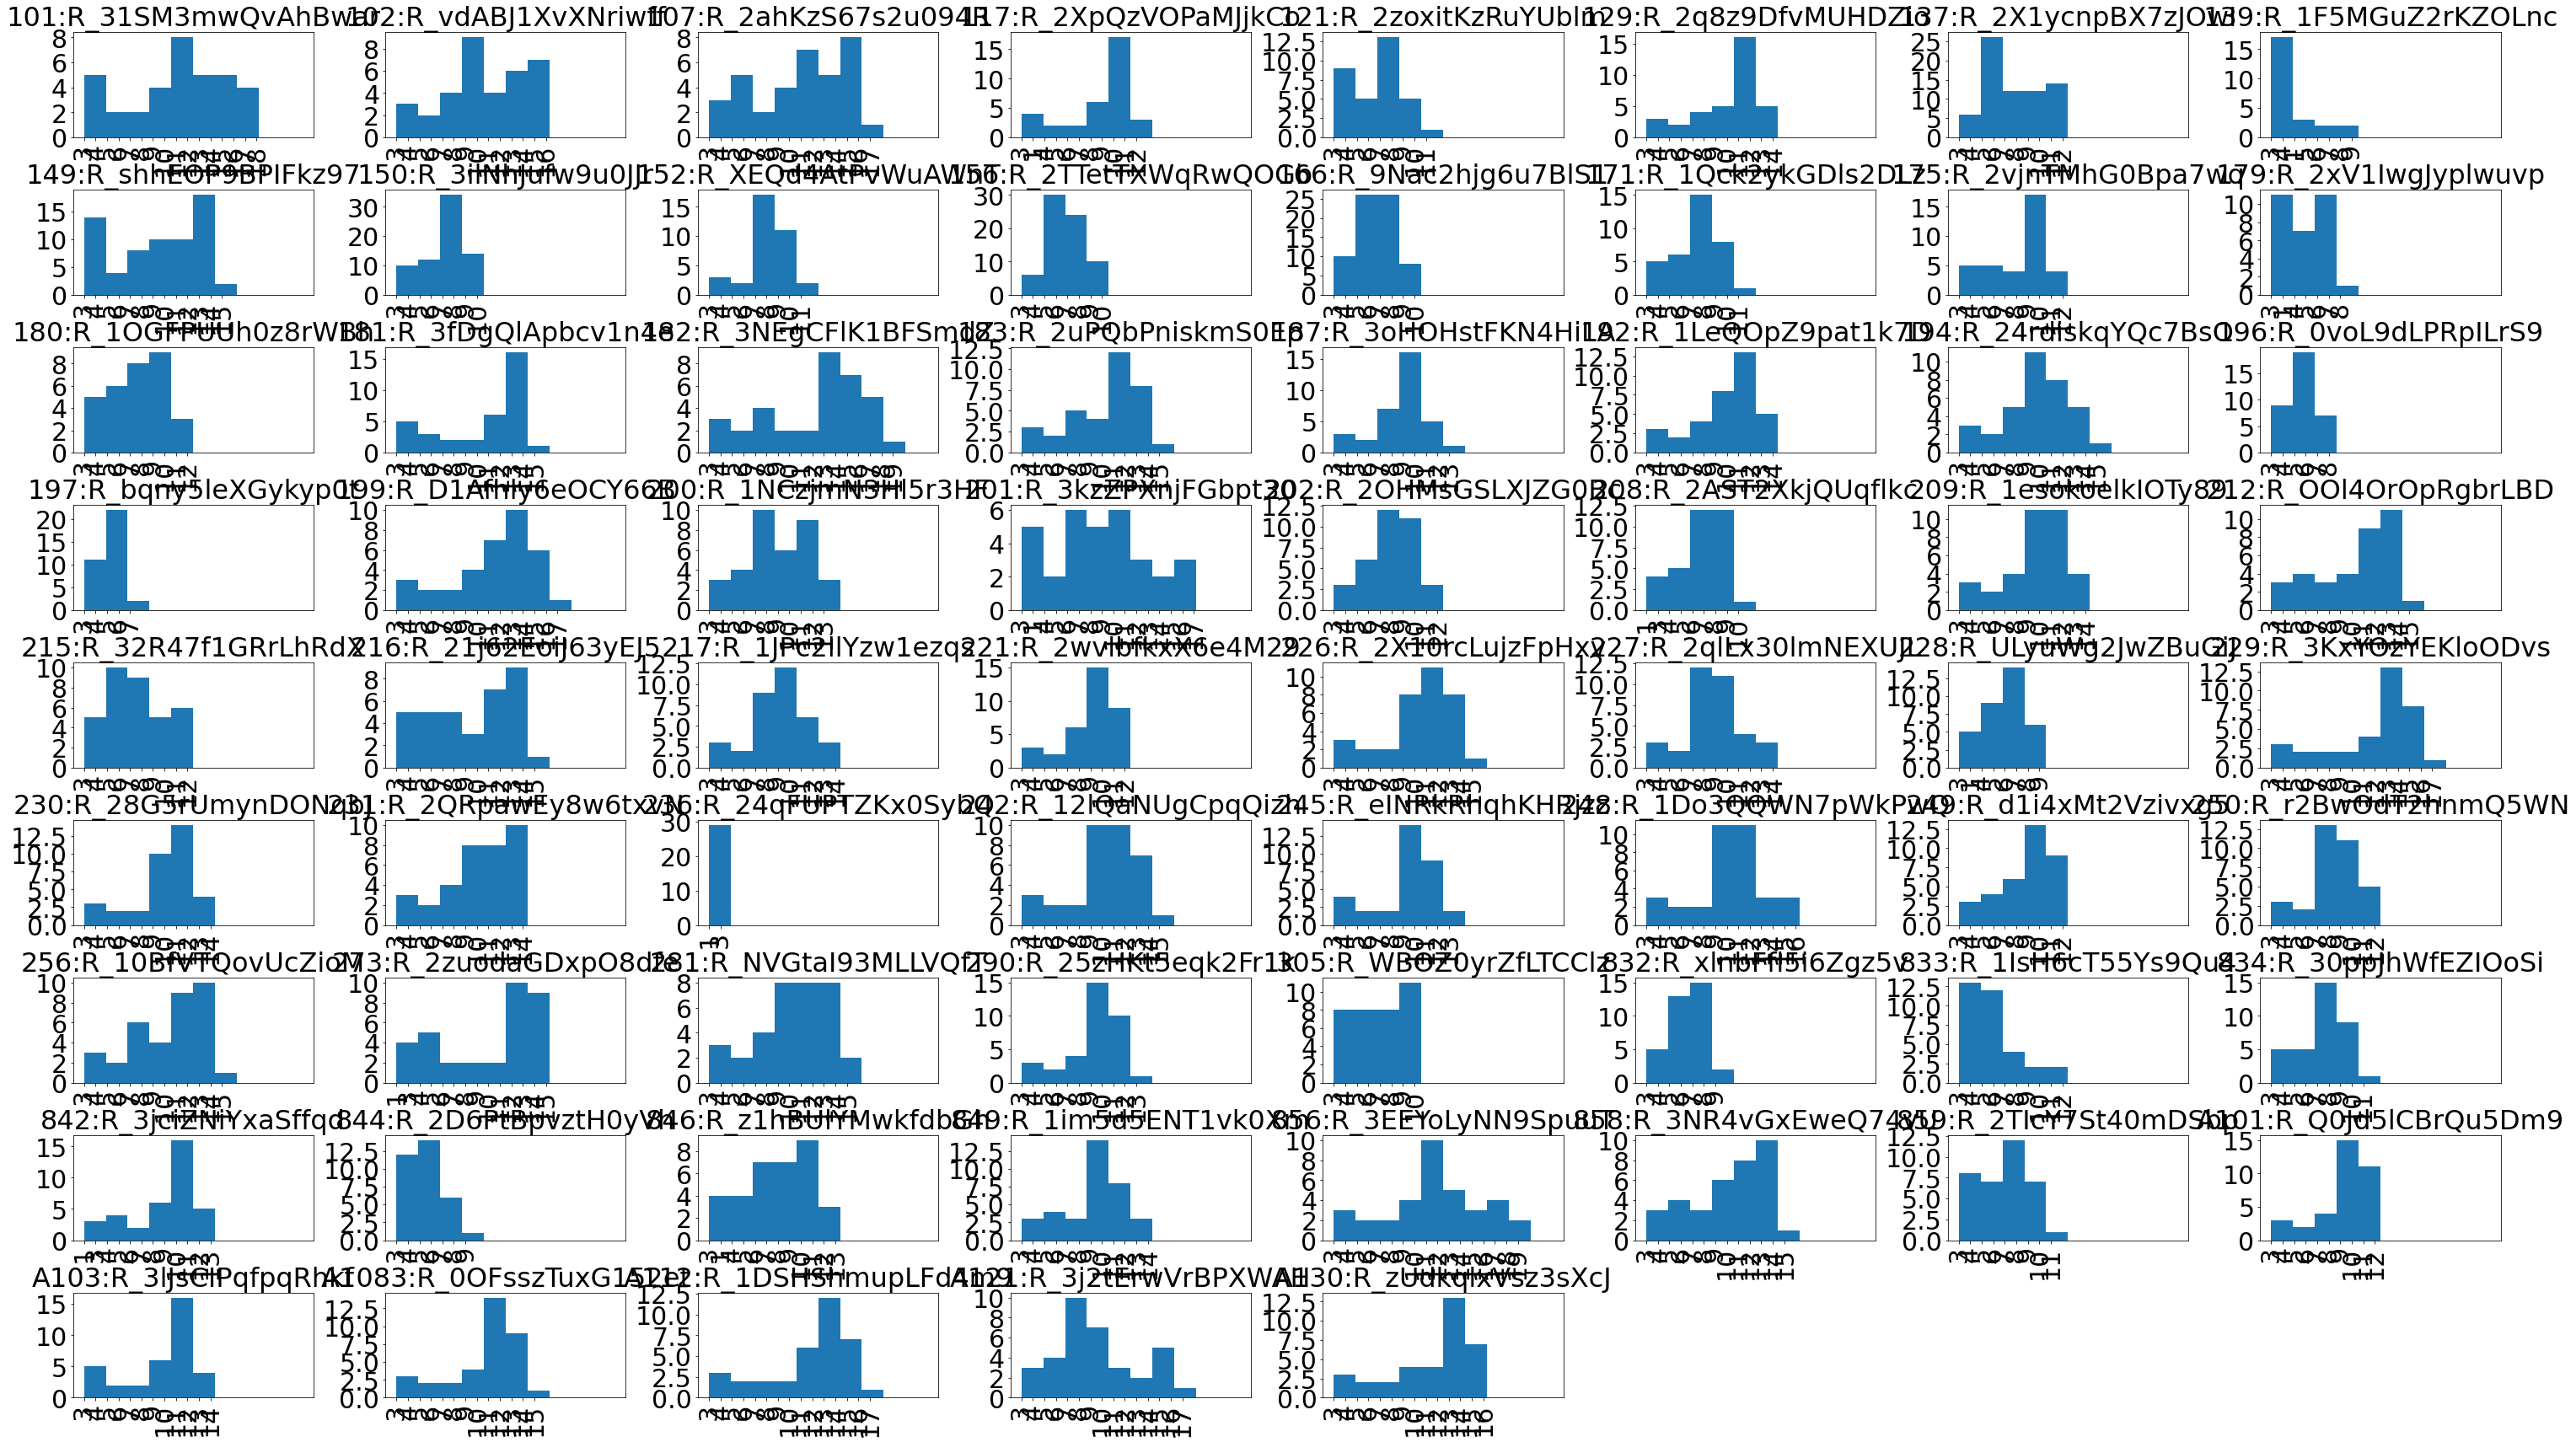

In [11]:
hists = dataFrame['category'].hist(by=dataFrame['subject'], range=[1,20], figsize=(50, 30), xlabelsize=30, ylabelsize=30)
for x in hists.ravel():
    x.title.set_size(32)


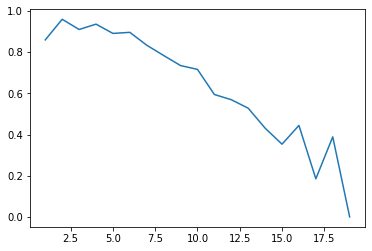

In [12]:
plt.figure()
dataFrame['count'] = 1
dataFrame['win'] = (dataFrame['outcome'] == '1').astype(int)
dataFrame['category'] = pd.to_numeric(dataFrame['category'])
dataWinCount = dataFrame.groupby(['subject', 'category'], as_index=False).sum()
dataWinCount['winRate'] = dataWinCount['win']/dataWinCount['count']
dataWinCount = dataWinCount.groupby(['category'], as_index=False).mean()

plt.plot(dataWinCount['category'],dataWinCount['winRate'] )

Text(0.5, 0, 'Category')

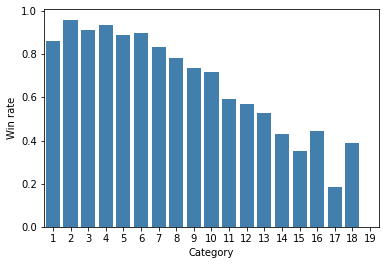

In [13]:
ax = sb.barplot(x="category", y="winRate", data=dataWinCount, ci = None, color = "#3182bd")
plt.ylabel("Win rate")
plt.xlabel("Category")

In [14]:
dataWinCount.head()

,category,count,win,winRate
0,1,4.700000,2.600000,0.860000
1,2,2.797101,2.623188,0.960286
2,3,2.898551,2.521739,0.910471
3,4,2.014706,1.735294,0.936485
4,5,2.573529,2.102941,0.891442


In [15]:
dataFrame['subjectNr'] = dataFrame['subject'].str.split(':').str[0]
age['subjectNr'] = age['StudyID']
df_age_cat = pd.merge(age, dataFrame, on='subjectNr', how='outer')
df_age_cat = df_age_cat[df_age_cat['gameNumber'].notna()]
df_age_winrate = df_age_cat.groupby(['subjectNr'], as_index=False).mean()
df_age_medcat = df_age_cat.groupby(['subjectNr'], as_index=False).median()
df_age_maxcat = df_age_cat.groupby(['subjectNr'], as_index=False).max()

# Get all games numbered 0 or 1 (practice and task)
first_games = df_age_cat[pd.to_numeric(df_age_cat['gameNumber']) < 2]
# First games has 4 games per subject: 2 practice 2 task
counter = range(int(len(first_games) / 4))
# Make a list of every 1st and 2nd game (practice games), so excluce every 3rd and 4th (task games)
indices = [x * 4 for x in counter]
indices.extend([x * 4 + 1 for x in counter])
indices.sort()
# Select all the practice games from the df so we can get a list of their indices
practice_games = first_games.iloc[indices]
# Remove the practice indices from df_age_cat. What's left are only task games.
df_age_cat = df_age_cat.drop(practice_games.index)

df_age_cat

,StudyID,Gender,ExactAge,FlooredAge,ageBins,subjectNr,subject,gameNumber,category,level,user_color,outcome,count,win
2,A112,F,19.6904,19.0,"(18, 26]",A112,A112:R_1DSHShmupLFd4m9,0,3.0,14,black,1,1.0,1.0
3,A112,F,19.6904,19.0,"(18, 26]",A112,A112:R_1DSHShmupLFd4m9,1,3.0,28,white,1,1.0,1.0
4,A112,F,19.6904,19.0,"(18, 26]",A112,A112:R_1DSHShmupLFd4m9,2,4.0,31,black,1,1.0,1.0
5,A112,F,19.6904,19.0,"(18, 26]",A112,A112:R_1DSHShmupLFd4m9,3,5.0,42,white,1,1.0,1.0
6,A112,F,19.6904,19.0,"(18, 26]",A112,A112:R_1DSHShmupLFd4m9,4,6.0,55,black,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2746,229,F,11.5014,11.0,"(7, 12]",229,229:R_3KxYOzYEKloODvs,30,12.0,112,black,1,1.0,1.0
2747,229,F,11.5014,11.0,"(7, 12]",229,229:R_3KxYOzYEKloODvs,31,12.0,117,white,1,1.0,1.0
2748,229,F,11.5014,11.0,"(7, 12]",229,229:R_3KxYOzYEKloODvs,32,13.0,127,black,1,1.0,1.0
2749,229,F,11.5014,11.0,"(7, 12]",229,229:R_3KxYOzYEKloODvs,33,14.0,138,white,-1,1.0,0.0


Text(0.5, 0, 'Subject')

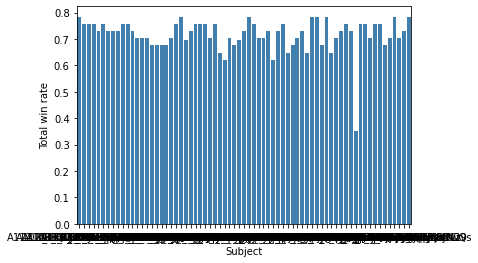

In [16]:
ax = sb.barplot(x="subject", y="win", data=dataFrame, ci = None, color = "#3182bd")
plt.ylabel("Total win rate")
plt.xlabel("Subject")


,StudyID,Gender,ExactAge,FlooredAge,ageBins,subjectNr,subject,gameNumber,category,level,user_color,outcome,count,win
30,A112,F,19.6904,19.0,"(18, 26]",A112,A112:R_1DSHShmupLFd4m9,28,15.0,147,black,1,1.0,1.0
60,A101,F,21.1151,21.0,"(18, 26]",A101,A101:R_Q0Jd5lCBrQu5Dm9,21,9.0,88,white,1,1.0,1.0
90,A121,F,19.7370,19.0,"(18, 26]",A121,A121:R_3j2tErwVrBPXWAH,14,9.0,88,black,-1,1.0,0.0
120,A1083,M,23.0630,23.0,"(18, 26]",A1083,A1083:R_0OFsszTuxG152et,7,9.0,84,white,1,1.0,1.0
150,A103,F,20.2438,20.0,"(18, 26]",A103,A103:R_3lJsCIPqfpqRhkf,0,3.0,12,black,1,1.0,1.0
180,A103,F,20.2438,20.0,"(18, 26]",A103,A103:R_3lJsCIPqfpqRhkf,30,12.0,110,black,-1,1.0,0.0
210,A130,M,22.0493,22.0,"(18, 26]",A130,A130:R_zUdkqlxVsz3sXcJ,23,13.0,121,white,1,1.0,1.0
240,101,F,17.4904,17.0,"(12, 18]",101,101:R_31SM3mwQvAhBwar,15,11.0,101,white,1,1.0,1.0
270,102,F,15.0055,15.0,"(12, 18]",102,102:R_vdABJ1XvXNriwff,8,10.0,98,black,1,1.0,1.0
300,107,M,12.7260,12.0,"(7, 12]",107,107:R_2ahKzS67s2u094R,1,3.0,19,white,1,1.0,1.0


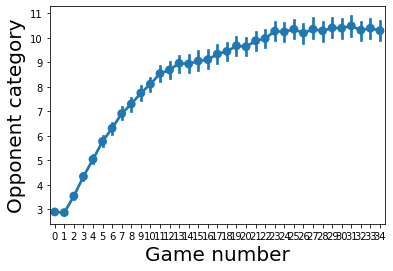

In [17]:
win_age = sb.pointplot(x="gameNumber", y="category", data=df_age_cat, ci =68)
plt.ylabel("Opponent category", fontsize=20)
plt.xlabel("Game number", fontsize=20)
bins = [7, 12, 18, 26]
df_age_cat['ageBins'] = pd.cut(df_age_cat['FlooredAge'], bins)
df_age_cat.loc[df_age_cat.index.intersection([x * 30 for x in range(20)]),:]

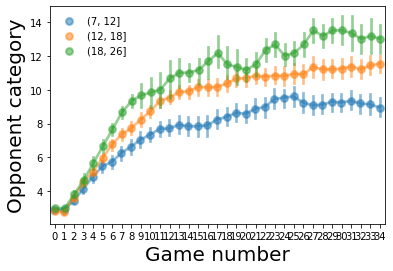

In [18]:
df_age_cat2 = df_age_cat
df_age_cat2["gameNumber"] = pd.to_numeric(df_age_cat2["gameNumber"])
win_age = sb.pointplot(x="gameNumber", y="category", data=df_age_cat2, ci =68, hue = "ageBins", dodge=True,plot_kws=dict(alpha=0.3))
plt.setp(win_age.collections, alpha=.5) #for the markers
plt.setp(win_age.lines, alpha=.5) 
plt.ylabel("Opponent category", fontsize=20)
plt.xlabel("Game number", fontsize=20)
plt.legend(loc='upper left', frameon=False)

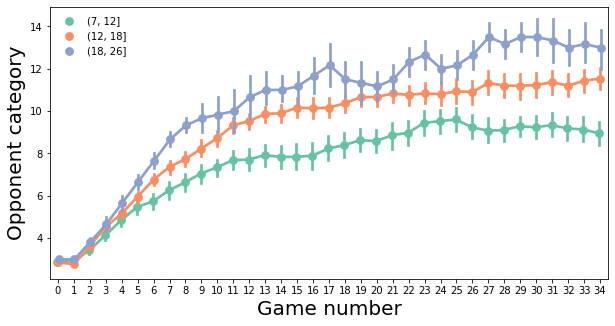

In [19]:
plt.figure(figsize=(10,5))
df_age_cat2 = df_age_cat
df_age_cat2["gameNumber"] = pd.to_numeric(df_age_cat2["gameNumber"])
win_age = sb.pointplot(x="gameNumber", y="category", data=df_age_cat2, ci =68, 
                       hue = "ageBins", dodge=True,plot_kws=dict(alpha=1), palette=sb.color_palette("Set2"),  
                       legend=False)
plt.setp(win_age.collections, alpha=1) #for the markers
plt.setp(win_age.lines, alpha=1) 
plt.ylabel("Opponent category", fontsize=20)
plt.xlabel("Game number", fontsize=20)
plt.legend(loc='upper left', frameon=False)

In [ ]:
pars_mean = pars.groupby(['StudyID'], as_index=False).mean()
win_age = sb.regplot(x="ExactAge", y="FeatureDropRate", data=pars_mean, ci =68, color = "green")
plt.ylabel("Feature drop rate", fontsize=20)
plt.xlabel("Age", fontsize=20)


Text(0.5, 0, 'Age')

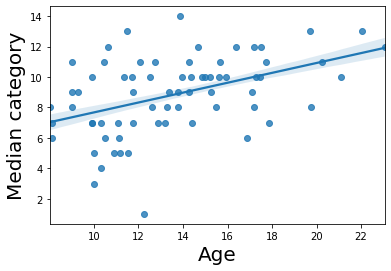

In [21]:
win_age = sb.regplot(x="ExactAge", y="category", data=df_age_medcat, ci =68)
plt.ylabel("Median category", fontsize=20)
plt.xlabel("Age", fontsize=20)


Text(0.5, 0, 'Age')

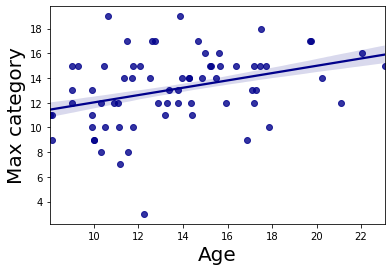

In [22]:
win_age = sb.regplot(x="ExactAge", y="category", data=df_age_maxcat, ci = 68, color = "Darkblue")
plt.ylabel("Max category", fontsize=20)
plt.xlabel("Age", fontsize=20)

Text(0.5, 0, 'Age')

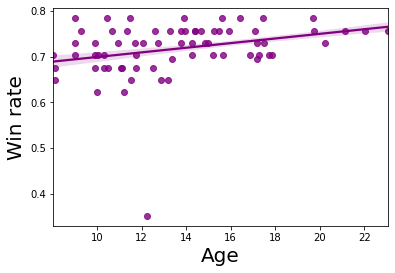

In [23]:
win_age = sb.regplot(x="ExactAge", y="win", data=df_age_winrate, ci=68, color = 'Purple')
plt.ylabel("Win rate", fontsize=20)
plt.xlabel("Age", fontsize=20)

    category     count       win   winRate
0          1  4.700000  2.600000  0.860000
1          2  2.797101  2.623188  0.960286
2          3  2.898551  2.521739  0.910471
3          4  2.014706  1.735294  0.936485
4          5  2.573529  2.102941  0.891442
5          6  3.029412  2.338235  0.896621
6          7  3.558824  2.661765  0.834121
7          8  3.537313  2.477612  0.784115
8          9  3.723077  2.523077  0.735293
9         10  4.295082  3.114754  0.716602
10        11  4.035714  2.375000  0.594707
11        12  3.823529  2.431373  0.569359
12        13  3.925000  2.350000  0.528155
13        14  3.176471  1.617647  0.431303
14        15  2.320000  1.080000  0.353333
15        16  2.416667  1.166667  0.444444
16        17  1.444444  0.444444  0.185185
17        18  2.000000  1.000000  0.388889
18        19  1.500000  0.000000  0.000000


<AxesSubplot:>

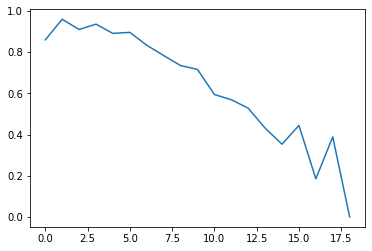

In [24]:
#plot winrate as function of category
dataFrame['count'] = 1
dataFrame['win'] = (dataFrame['outcome'] == '1').astype(int)
dataFrame['category'] = pd.to_numeric(dataFrame['category'])
dataWinCount = dataFrame.groupby(['subject', 'category'], as_index=False).sum()
dataWinCount['winRate'] = dataWinCount['win']/dataWinCount['count']
dataWinCount = dataWinCount.groupby(['category'], as_index=False).mean()
print(dataWinCount)
dataWinCount['winRate'].plot.line()

In [ ]:
inputDir = '/Users/ilima/Google Drive/Projects/Cate Hartley Weiji/4inarow_fitting_results'
with open(inputDir + '/paramsMatrix.csv', 'w') as outfile:
    for subject in range(48):
        for paramnr in range(5):
            outfile.write(str(subject+1)+','+str(paramnr+1) + ',')
            with open(inputDir + '/' + str(subject + 1) + '/' + 'params' + str(paramnr+1) + '.csv')as infile:
                line = infile.readline()
                outfile.write(line)